In [1]:
import cv2
import imageio
import json
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

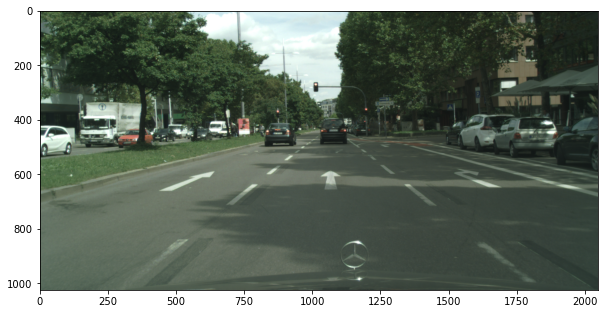

In [2]:
data_path = 'data/front_view.png'
rgb = imageio.imread(data_path)
plt.figure(figsize=(10, 10))
plt.imshow(rgb)

In [3]:
# From world to camera coordinates
camera_params_path = 'camera_params.json'
camera_params = None
with open(camera_params_path, 'r') as fh:
    camera_params = json.load(fh)
print(camera_params)

{'baseline': 0.21409619719999115, 'pitch': 0.03842560000000292, 'roll': 0.0, 'yaw': -0.009726800000000934, 'x': 1.7, 'y': 0.026239999999999368, 'z': 1.212400000000026, 'fx': 2263.54773399985, 'fy': 2250.3728170599807, 'cx': 1079.0175620000632, 'cy': 515.0066006000195}


In [4]:
b = camera_params['baseline']

K = np.array([
    [camera_params['fx'], 0.0, camera_params['cx']],
    [0.0, camera_params['fy'], camera_params['cy']],
    [0.0, 0.0, 1.0]
]).astype(np.float32)

Kinv = np.linalg.inv(K)

print(K.shape)

# theta_x (roll), theta_y (pitch), theta_z (yaw)
rotation_euler_angles = np.array([ camera_params['roll'], camera_params['pitch'], camera_params['yaw'] ])
# Rotation matrix R = Rx*Ry*Rz

t = np.array([ camera_params['x'], camera_params['y'], camera_params['z'] ])

(3, 3)


In [5]:
# pnt_cam = H_c2v*H_v2r(t)*pnt_road
def rotation_mat(euler_angles):
    theta_x, theta_y, theta_z = euler_angles
    Rz = np.array([
        np.cos(theta_z), -np.sin(theta_z), 0.0,
        np.cos(theta_z), np.sin(theta_z), 0.0,
        0.0, 0.0, 1.0,
    ]).reshape(3, 3)
    Ry = np.array([
        np.cos(theta_y), -np.sin(theta_y), 0.0,
        0.0, 1.0, 0.0,
        np.cos(theta_y), 0.0, np.cos(theta_y),
    ]).reshape(3, 3)
    Rx = np.array([
        1.0, 0.0, 0.0,
        0.0, np.cos(theta_x), -np.sin(theta_x),
        0.0, np.sin(theta_x), np.cos(theta_x),
    ]).reshape(3, 3)
    return Rz.dot(Ry.dot(Rx))

In [6]:
# From car coords to camera coords: R and t
R = rotation_mat(rotation_euler_angles)
R_inv = np.linalg.pinv(R)
t_inv = -t # a' = a + t => a = a' - t

In [7]:
# From car coords to camera coords
H_v2c = np.array([
    *R_inv[0, :], t_inv[0],
    *R_inv[1, :], t_inv[1],
    *R_inv[2, :], t_inv[2],
]).reshape(3, 4).astype(np.float32)

print(H_v2c)

[[ 2.4766407e+00 -1.4758545e+00 -1.0329884e-16 -1.7000000e+00]
 [ 5.1405178e+01 -5.1405178e+01 -7.1872016e-15 -2.6240001e-02]
 [-2.4766407e+00  1.4758545e+00  1.0007387e+00 -1.2124000e+00]]


In [8]:
print(f'{rgb.shape[1]} x {rgb.shape[0]}\n')
x = np.linspace(0, rgb.shape[1] - 1, rgb.shape[1])
y = np.linspace(0, rgb.shape[0] - 1, rgb.shape[0])
xx, yy = np.meshgrid(x, y)
print(xx.shape)
print(yy.shape)

2048 x 1024

(1024, 2048)
(1024, 2048)


In [9]:
# select a region on the road, project back to set the boundaries, and deproject back to road
road_side = 500
scale = 0.1 #m/pxl (from calibration)

In [31]:
# Define our road plane (we define it, relative to the vehicle, say): [X, Y, Z=0]
road_img = np.zeros(shape=(road_side, road_side, 3)).astype(np.int32)

h = road_side // 2
for row in range(0, road_side):
    for col in range(0, road_side):
        # in meters (3D pnt)
        road_pnt = np.array([ col, np.abs(row - h), 0, 1]).T * scale
        img_pnt = Kinv.dot(H_v2c.dot(road_pnt)).astype(np.int32)
        # Without sampling
        rgb_val = rgb[img_pnt[1]][img_pnt[0]] if img_pnt[0] > 0 and img_pnt[0] < rgb.shape[1] and img_pnt[1] > 0 and img_pnt[1] < rgb.shape[0] else np.zeros(shape=(3))
        road_img[row][col] = rgb_val

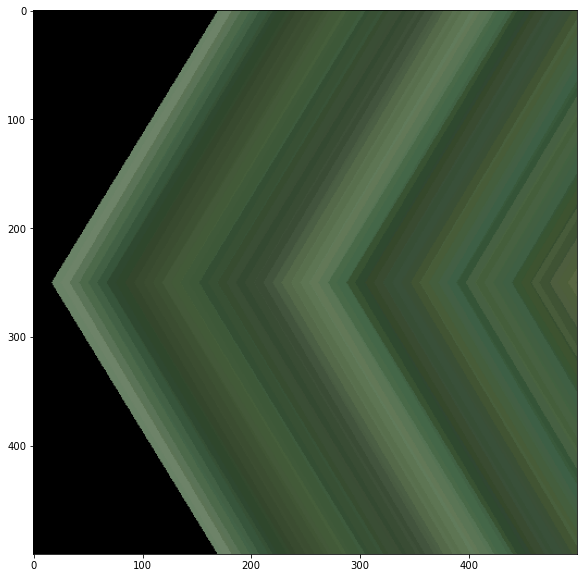

In [32]:
plt.figure(figsize=(10, 10))
plt.imshow(road_img)